# Figure 2

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy
import os
import dolfin
import get_invariants_article_gravity 
import pandas as pd
import shutil

import dolfin_mech                    as dmech


import importlib
importlib.reload(dmech) #### to reimport module in Jupyter notebooks if necessary


<module 'dolfin_mech' from '/Users/peyrault/dolfin_mech/dolfin_mech/__init__.py'>

## Creating folder for temporary files

In [2]:
current_directory=os.getcwd()
new_directory="calc_fig8"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

In [3]:
alpha = 0.16
gamma = 0.5
c1 = 1.2
c2 = 0. ## obsolete parameter
rho_solid =  1.06e-6


params = {
        "alpha": alpha,
        "gamma":gamma,
        "c1":c1,
        "c2":c2,
        "kappa":1e2,
        "eta":1e-5,
        "rho_solid":rho_solid}

mat_params = {"scaling":"linear", "parameters": params}

## Loading

In [4]:
pe, pi = -0.5, -3. ### pleural pressure values 

breathing_constants=[0, -0.005, 0.005, -0.0065, 0.0065] ### different types of breathing

## Mesh

In [5]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf"}


## Computing end-exhalation and end-inhalation configurations to compute the invariants, for different types of breathing

In [6]:
invariants={}
for h in breathing_constants:

    load_params_inverse = {
        "type":"p_boundary_condition0", "f":9.81e3, "P0" : float(pe), "H":h}
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f":9.81e3, "P0" : float(pe), "H":h}
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f":9.81e3, "P0" : float(pi), "H":h}


    ##### computing the reference configuration, trough an inverse problem
    Uref, phisref_computation, V_expi_ini, V_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=1,
            mat_params=mat_params,
            load_params=load_params_inverse,
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":1},
            res_basename=res_basename+"/reference",
            cube_params=cube_params,
            verbose=1)


    ##### assuming that porosity is uniform in the unloaded configuration, and taking the same starting values for the problem with and the problem without gravity 

    phisref_imposed=[numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]

    U_exhal, phisexhal_g, V_unloaded, V_exhal = dmech.run_RivlinCube_PoroHyperelasticity(
                inverse=0,
                mat_params=mat_params,
                load_params=load_params_direct_exhalation,
                get_results=1,
                inertia=1,
                step_params={"dt_min":1e-4, "dt_ini":0.125},
                res_basename = res_basename+"/exhalation",
                cube_params=cube_params,
                porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                move = {"move":True, "U":Uref},
                verbose=1)

    print("exhal config computed")
        

    U_inhal, phisinhal, V_unloaded, Vinhal = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=0,
            mat_params=mat_params,
            load_params=load_params_direct_inhalation,
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":0.125},
            res_basename = res_basename+"/inhalation",
            cube_params=cube_params,
            porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
            move = {"move":True, "U":Uref},
            verbose=1)

    print("inhal config computed")

    mesh = dolfin.Mesh()
    mesh_name = str(cube_params["path_and_mesh_name"])
    dolfin.XDMFFile(mesh_name).read(mesh)
    dolfin.ALE.move(mesh, Uref)

    invariants_mesh = get_invariants_article_gravity.get_invariants(U_exhal=U_exhal, U_inhal=U_inhal, mesh=mesh)
    invariants["h="+str(h)]=invariants_mesh

Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
exhal config computed
inhal config computed
Iterating over subset, found 363 entities out of 4052.
Iterating over subset, found 303 entities out of 4052.
Iterating over subset, found 344 entities out of 4052.
Iterating over subset, found 310 entities out of 4052.
Iterating over subset, found 434 entities out of 4052.
Iterating over subset, found 422 entities out of 4052.
Iterating 

In [7]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Post-processing

### Reading data from Hurtado et al. for comparison

In [8]:
J=pd.read_table("Hurtado_data/J.dat", sep="\s+", usecols=['zone', 'mean', 'std+', 'std-']).to_dict('list')
I1=pd.read_table("Hurtado_data/I1.dat", sep="\s+", usecols=['zone', 'mean', 'std+', 'std-']).to_dict('list')
I2=pd.read_table("Hurtado_data/I2.dat", sep="\s+", usecols=['zone', 'mean', 'std+', 'std-']).to_dict('list')

## Generating plots

### J

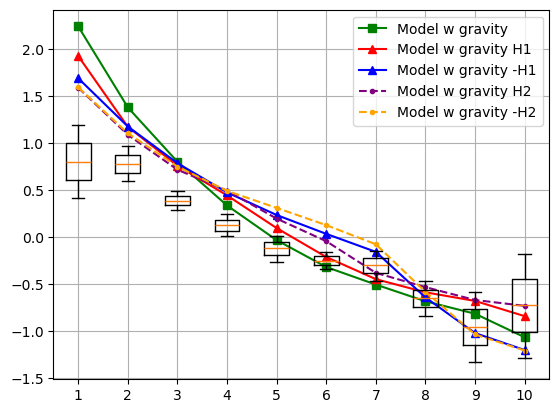

In [9]:
figJ, axJ = plt.subplots()

data = [[J["mean"][i], J["std+"][i], J["std-"][i]] for i in range(len(J["zone"]))]

plt.plot(invariants["h=0"]["zone"], invariants["h=0"]["J^"], color='green', linestyle='-',  marker="s", label='Model w gravity')
plt.plot(invariants["h=0.005"]["zone"], invariants["h=0.005"]["J^"], color='red', linestyle='-', marker="^", label='Model w gravity H1')
plt.plot(invariants["h=-0.005"]["zone"], invariants["h=-0.005"]["J^"], color='blue', linestyle='-', marker="^", label='Model w gravity -H1')
plt.plot(invariants["h=0.0065"]["zone"], invariants["h=0.0065"]["J^"], color='purple', linestyle='--', marker=".", label='Model w gravity H2')
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["J^"], color='orange', linestyle='--', marker=".", label='Model w gravity -H2')

axJ.boxplot(data)

plt.grid()

plt.legend()
plt.show()


### I1

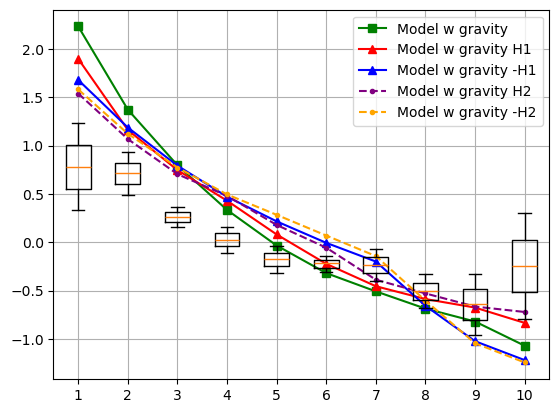

In [10]:
figJ, axJ = plt.subplots()

data = [[I1["mean"][i], I1["std+"][i], I1["std-"][i]] for i in range(len(J["zone"]))]

plt.plot(invariants["h=0"]["zone"], invariants["h=0"]["I1^"], color='green', linestyle='-',  marker="s", label='Model w gravity')
plt.plot(invariants["h=0.005"]["zone"], invariants["h=0.005"]["I1^"], color='red', linestyle='-', marker="^", label='Model w gravity H1')
plt.plot(invariants["h=-0.005"]["zone"], invariants["h=-0.005"]["I1^"], color='blue', linestyle='-', marker="^", label='Model w gravity -H1')
plt.plot(invariants["h=0.0065"]["zone"], invariants["h=0.0065"]["I1^"], color='purple', linestyle='--', marker=".", label='Model w gravity H2')
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["I1^"], color='orange', linestyle='--', marker=".", label='Model w gravity -H2')



axJ.boxplot(data)

plt.grid()

plt.legend()
plt.show()

### I2

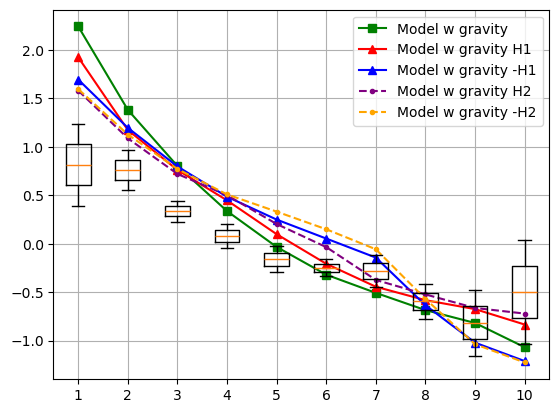

In [11]:
figJ, axJ = plt.subplots()

data = [[I2["mean"][i], I2["std+"][i], I2["std-"][i]] for i in range(len(I2["zone"]))]

plt.plot(invariants["h=0"]["zone"], invariants["h=0"]["I2^"], color='green', linestyle='-',  marker="s", label='Model w gravity')
plt.plot(invariants["h=0.005"]["zone"], invariants["h=0.005"]["I2^"], color='red', linestyle='-', marker="^", label='Model w gravity H1')
plt.plot(invariants["h=-0.005"]["zone"], invariants["h=-0.005"]["I2^"], color='blue', linestyle='-', marker="^", label='Model w gravity -H1')
plt.plot(invariants["h=0.0065"]["zone"], invariants["h=0.0065"]["I2^"], color='purple', linestyle='--', marker=".", label='Model w gravity H2')
plt.plot(invariants["h=-0.0065"]["zone"], invariants["h=-0.0065"]["I2^"], color='orange', linestyle='--', marker=".", label='Model w gravity -H2')

axJ.boxplot(data)

plt.grid()

plt.legend()
plt.show()